# Project - File QA-RAG Chatbot App with ChatGPT, LangChain, and Streamlit
* Notebook by Adam Lang
* Date: 11/10/24

# Overview
* In this notebook I am going to implement an Advanced RAG system with ChatGPT, LangChain, and Streamlit to build a "File-QA UI driven Chatbot".
* The features are as follows:
1. PDF Document upload and indexing (create embeddings).
2. RAG system for query analysis and response.
3. Result streaming capabilities (Real-time output).
4. Show document source of the answer from RAG system.
  * This is an important component being able to display the source of the information to the user.


# Architecture Overview
1. User uploads docs via the User interace.
  * Documents will be split and chunked.
  * Embeddings created.
  * Store all in Vector database.

2. QA-RAG system
  * User question sent to system.
  * User question embedded and sent to vector DB.
  * Semantic similarity search performed using cosine similarity.
  * ANN search performed and similar docuemnts retrieved.
  * Documents sent to ChatGPT or LLM of choice.
  * Augmented answer with real-time knowledge then used to synthesize a Generative AI answer.

# Install dependencies

In [1]:
!pip install --upgrade streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip install langchain==0.1.12
!pip install langchain-openai==0.0.8
!pip install langchain-community==0.0.29
!pip install streamlit==1.32.2 #user interface
!pip install PyMuPDF==1.24.0 #library to process PDF files
!pip install chromadb==0.4.24 #vector database
!pip install pyngrok==7.1.5 # python wrapper for ngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.1/303.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-s

# Setup Environment

In [3]:
from getpass import getpass

OPENAI_KEY = getpass('Enter your open AI key: ')

Enter your open AI key: ··········


In [4]:
## ngrok key

NGROK_API_KEY = getpass('Enter your ngrok key: ')

Enter your ngrok key: ··········


In [5]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['NGROK_API_KEY'] = NGROK_API_KEY

# Write app code and store in .py file

In [6]:
## below is a magic command it will write all code to a .py file
## we then deploy the app.py file to a cloud server where colab is running
## if by chance you have your own server you can write your code in your own app.py and deploy direct from there
%%writefile app.py

## imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_message_histories import StreamlitChatMessageHistory
from langchain_core.callbacks.base import BaseCallbackHandler
from langchain_community.document_loaders import PyMuPDFLoader #PDF loader
from langchain_text_splitters import RecursiveCharacterTextSplitter # text splitter
from langchain_community.vectorstores.chroma import Chroma # vector DB
from operator import itemgetter
import streamlit as st # User interface
import tempfile
import os
import pandas as pd # df processing

# Customize initial app landing page
st.set_page_config(page_title="File QA Chatbot", page_icon="🤖")
st.title("Welcome to File QA RAG Chatbot 🤖")


#@st.cache_data(ttl=3600) #can also use @st.cach_resources(ttl="1h")
# function that takes in uploaded PDFs, creates doc chunks, computes embeddings
# stores doc chunks and embeddings in Vector DB
# returns retriever which can index embeddings in Vector DB -- to return docs based on user input
# stores in a cache
def configure_retriever(uploaded_files):
  """
  Function that extracts text from PDF files, breaks into chunks,
  creates embeddings and stores in Vector DB
  """
  # 1. read documents -- cache's for 1 hour
  docs = []
  temp_dir = tempfile.TemporaryDirectory()
  for file in uploaded_files:
    temp_filepath = os.path.join(temp_dir.name, file.name)
    with open(temp_filepath, "wb") as f: #open file
      f.write(file.getvalue())
    loader = PyMuPDFLoader(temp_filepath) #extract text from PDFs
    docs.extend(loader.load())


  # 2. split into document chunks
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500,
                                                 chunk_overlap=200) #configurable chunks sizes

  # create chunks
  doc_chunks = text_splitter.split_documents(docs)

  # 3. Create document embeddings and store in Vector DB
  embeddings_model = OpenAIEmbeddings() #load embedding model
  vectordb = Chroma.from_documents(doc_chunks, embeddings_model) # create embeddings + store/index in vector DB

  # 4. Define retriever object
  ## Purpose: retrieve similar chunks from vector DB
  retriever = vectordb.as_retriever()
  return retriever


# manages live updates to Streamlit app's display by appending new text tokens
# to existing text stream and rendering updated text in Markdown
class StreamHandler(BaseCallbackHandler):
  def __init__(self, container, initial_text=""):
    self.container = container
    self.text = initial_text

  def on_llm_new_token(self, token: str, **kwargs) -> None:
    self.text += token
    self.container.markdown(self.text)

# creates UI element "sidebar" to accept PDF uploads
uploaded_files = st.sidebar.file_uploader(
    label="Uploaded PDF files",
    type=['pdf'],
    accept_multiple_files=True #accepts multiple PDF files at once
)
if not uploaded_files:
  st.info("Please upload PDF documents to continue.")
  st.stop()

# create retriever object based on uploaded PDF files
retriever = configure_retriever(uploaded_files)

# load connection to ChatGPT LLM -- or LLM of choice
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo',
                     temperature=0.1,
                     streaming=True)

# create prompt template for QA RAG system
qa_template = """
                Use only the following pieces of context to answer the question at the end.
                If you don't know the answer, just say that you don't know,
                don't try to make up an answer. Keep the answer as concise as possible.

                {context}

                Question: {question}
                """

## init prompt
qa_prompt = ChatPromptTemplate.from_template(qa_template)

# This function will format retrieved documents before sending to LLM
# every document retrieved --> spaced with 2 new lines
def format_docs(docs):
  return "\n\n".join([d.page_content for d in docs])


# Create QA-RAG System chain
qa_rag_chain = (
    {
        "context": itemgetter("question") # based on user question get context documents
          |
        retriever #retrieve relevant docs from vector DB
          |
        format_docs,
        "question": itemgetter("question") # user question

    }
      |
    qa_prompt # prompt with above user question and context
      |
    chatgpt # above prompt is sent to LLM for response

)
# store conversation history in Streamlit session state
streamlit_msg_history = StreamlitChatMessageHistory(key="langchain_messages")

# shows first message when app starts
if len(streamlit_msg_history.messages) == 0:
  streamlit_msg_history.add_ai_message("Please ask your question?")

# Render current messages from StreamlitChatMessageHistory
for msg in streamlit_msg_history.messages:
  st.chat_message(msg.type).write(msg.content)

# callback handler which does some post-processing on LLM response
# Used to post top 3 document sources used by LLM in RAG response
class PostMessageHandler(BaseCallbackHandler):
  def __init__(self, msg: st.write):
    BaseCallbackHandler.__init__(self)
    self.msg = msg
    self.sources = []

  def on_retriever_end(self, documents, *, run_id, parent_run, **kwargs):
    source_ids = []
    for d in documents: # retrieved docs from retriever based on user query
      metadata = {
          "source": d.metadata['source'], ## extract source of info
          "page": d.metadata['page'], ## extract source page number
          "content": d.page_content[:200] ## extract most relevant part of page content
      }
      idx = (metadata['source'], metadata['page'])
      if idx not in source_ids: # ONLY store unique source documents once found
        source_ids.append(idx)
        self.sources.append(metadata)

  def on_llm_end(self, response, *, run_id, parent_run_id, **kwargs):
    if len(self.sources):
      st.markdown("__Sources:__ "+"\n")
      st.dataframe(data=pd.DataFrame(self.sources[:3]), # display sources in df
                   width=1000) # Top 3 sources



# If user inputs a new prompt, display it and show response
if user_prompt := st.chat_input():
  st.chat_message("human").write(user_prompt)
  # This is where response from LLM is displayed
  with st.chat_message("ai"):
    # initializing an empty data stream
    stream_handler = StreamHandler(st.empty())
    # UI element to write RAG sources used after LLM response
    sources_container = st.write("")
    pm_handler = PostMessageHandler(sources_container)
    config = {"callbacks": [stream_handler, pm_handler]} ## stream results live
    # Get LLM response
    response = qa_rag_chain.invoke({"question": user_prompt},
                                   config)


Writing app.py


# Deploy/Start Application

In [7]:
!streamlit run app.py --server.port=8989 &>./logs.txt &

In [9]:
from pyngrok import ngrok
import yaml

# Terminate open tunnels if exist
ngrok.kill()

# set authtoken
# get your authtoken from `ngrok_credentials.yml' file
# Assuming ngrok_credentials.yml contains:
# ngrok_key: <your_actual_key>

with open('ngrok_credentials.yml', 'r') as file:
  NGROK_AUTH_TOKEN = yaml.safe_load(file)

# Access the auth token correctly using the dictionary key
ngrok.set_auth_token(NGROK_AUTH_TOKEN['ngrok_key'])


# OPEN an HTTPS tunnel on port XXX which you get from your `logs.tx` file
ngrok_tunnel = ngrok.connect(8989)
print("Streamlit App:", ngrok_tunnel.public_url)

Streamlit App: https://deeb-35-196-234-183.ngrok-free.app


Final Product
* The final product should look like this:
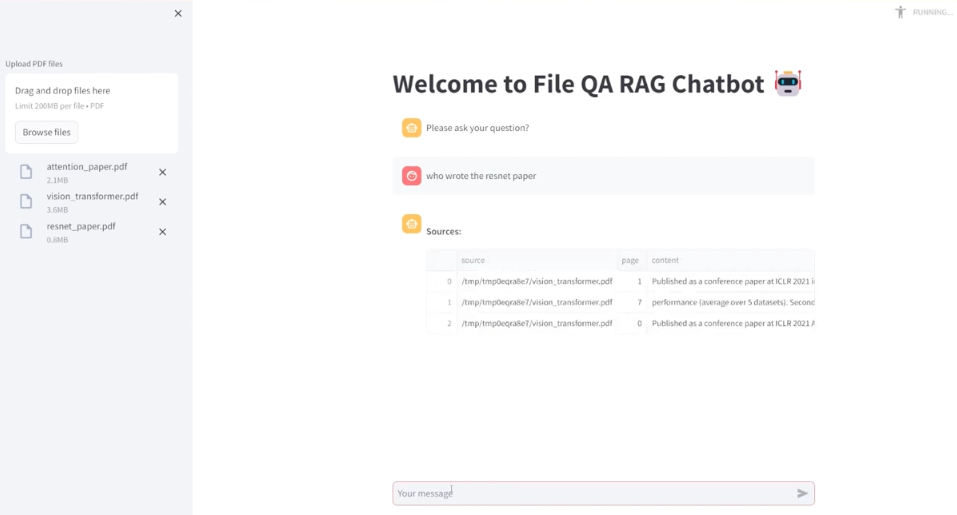